In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from numba import cuda

tf.keras.backend.clear_session()


In [ ]:
os.makedirs(main_dir + 'dogs/')
os.makedirs(main_dir + 'cats/')

In [5]:
main_dir = '../data/dogs-vs-cats/'
train_dir = main_dir + 'train/'
test_dir = main_dir + 'test1/'
dog_dir = main_dir + 'dogs/'
cat_dir = main_dir + 'cats/'


In [7]:
from shutil import copyfile
dog_cnt = 0
cat_cnt = 0
for files in os.listdir(train_dir):
    
    if 'cat' in files:
        copyfile(train_dir+files,cat_dir+files)
        cat_cnt  += 1
        
    if 'dog' in files:
        copyfile(train_dir+files,dog_dir+files)
        dog_cnt  += 1
        


Dogs Images :12500


NameError: name 'pritn' is not defined

In [8]:
print("Dogs Images :" + str(dog_cnt))
print("Cats Images : "+ str(cat_cnt))

Dogs Images :12500
Cats Images : 12500


In [10]:
import os

if not os.path.exists('../data/dogs-vs-cats/training/'):
    os.makedirs('../data/dogs-vs-cats/training/')

if not os.path.exists('../data/dogs-vs-cats/validation/'):
    os.makedirs('../data/dogs-vs-cats/validation/')
    
if not os.path.exists('../data/dogs-vs-cats/training/dogs/'):
    os.makedirs('../data/dogs-vs-cats/training/dogs/')

if not os.path.exists('../data/dogs-vs-cats/training/cats/'):
    os.makedirs('../data/dogs-vs-cats/training/cats/')
    

if not os.path.exists('../data/dogs-vs-cats/validation/dogs/'):
    os.makedirs('../data/dogs-vs-cats/validation/dogs/')

if not os.path.exists('../data/dogs-vs-cats/validation/cats/'):
    os.makedirs('../data/dogs-vs-cats/validation/cats/')


In [21]:
train_dir = '../data/dogs-vs-cats/training/'
valid_dir = '../data/dogs-vs-cats/validation/'

dogs_train_dir = '../data/dogs-vs-cats/training/dogs/'
cats_train_dir = '../data/dogs-vs-cats/training/cats/'

dogs_valid_dir = '../data/dogs-vs-cats/validation/dogs/'
cats_valid_dir = '../data/dogs-vs-cats/validation/cats/'

In [21]:
def split_images(SOURCE,SOURCE_TRAIN,SOURCE_VALID,SPLIT):
    images = os.listdir(SOURCE)
    images_cnt = len(images)
    train_split = int(images_cnt * SPLIT)
    valid_split = int(images_cnt - train_split)
    
    train_cnt = 0
    valid_cnt = 0
    
    for cnt in range(train_split):
        choice = random.choice(images)
        copyfile(SOURCE+choice,SOURCE_TRAIN+choice)
        train_cnt += 1
        images.remove(choice)
    for cnt in range(valid_split):
        choice = random.choice(images)
        copyfile(SOURCE+choice,SOURCE_VALID+choice)
        valid_cnt += 1
        images.remove(choice)
        
    print("Train Count : " +str(train_cnt))
    print("Valid Count : "+ str(valid_cnt))
        
        

In [22]:
split_images(dog_dir,dogs_train_dir,dogs_valid_dir,0.7)

Train Count : 8750
Valid Count : 3750


In [23]:
split_images(cat_dir,cats_train_dir,cats_valid_dir,0.7)

Train Count : 8750
Valid Count : 3750


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  rotation_range = 40,
                                  shear_range=0.2,
                                  width_shift_range = 0.2,
                                  fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [23]:
batch_size = 16
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150),
                                                   class_mode='binary',
                                                   batch_size = batch_size)

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   target_size=(150,150),
                                                   class_mode='binary',
                                                   batch_size = batch_size)



Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)), #148x148
    tf.keras.layers.MaxPooling2D(2,2),                                          #74x74
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),                         #72x72
    tf.keras.layers.MaxPooling2D(2,2),                                          #36x36
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),                         #34x34
    tf.keras.layers.MaxPooling2D(2,2),                                          #17x17
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),                         #15x15
    tf.keras.layers.MaxPooling2D(2,2),                                          #7x7
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

In [29]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [32]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if logs.get('acc')>0.96:
            print("Reached 96% accuracy so cancelling training.")
            self.model.stop_training = True

In [33]:
callbacks = MyCallback()

In [34]:
history = model.fit_generator(train_generator,
                             validation_data=valid_generator,
                             epochs = 30,
                             steps_per_epoch=17500/batch_size,
                             validation_steps=7500/batch_size,
                             callbacks=[callbacks])

Epoch 1/30
1094/1093 [==============================] - 278s 254ms/step - loss: 0.6793 - acc: 0.5635 - val_loss: 0.6641 - val_acc: 0.6448
Epoch 2/30
1094/1093 [==============================] - 148s 135ms/step - loss: 0.6337 - acc: 0.6553 - val_loss: 0.6331 - val_acc: 0.6405
Epoch 3/30
1094/1093 [==============================] - 147s 134ms/step - loss: 0.6047 - acc: 0.6789 - val_loss: 0.5930 - val_acc: 0.6692
Epoch 4/30
1094/1093 [==============================] - 148s 136ms/step - loss: 0.5749 - acc: 0.7034 - val_loss: 0.6202 - val_acc: 0.6721
Epoch 5/30
1094/1093 [==============================] - 149s 137ms/step - loss: 0.5457 - acc: 0.7291 - val_loss: 0.5782 - val_acc: 0.7127
Epoch 6/30
1094/1093 [==============================] - 152s 139ms/step - loss: 0.5279 - acc: 0.7366 - val_loss: 0.5118 - val_acc: 0.7497
Epoch 7/30
1094/1093 [==============================] - 164s 150ms/step - loss: 0.5127 - acc: 0.7497 - val_loss: 0.5414 - val_acc: 0.7343
Epoch 8/30
1094/1093 [============

In [35]:
model.save('dogs-vs-cats.h5')

In [2]:
model = tf.keras.models.load_model('dogs-vs-cats.h5')

Text(0.5, 1.0, 'Training Loss vs Validation Accuracy')

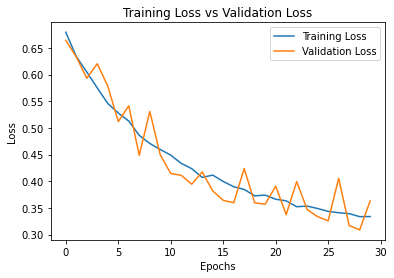

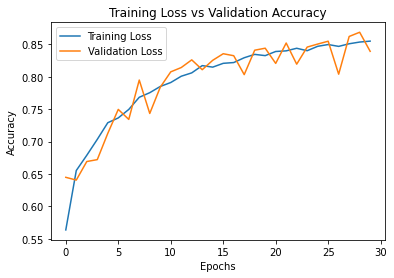

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(["Training Loss","Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")

plt.figure()
plt.plot(acc)
plt.plot(val_acc)
plt.legend(["Training Loss","Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Loss vs Validation Accuracy")


In [25]:
label_map = (train_generator.class_indices)
print(label_map)

{'cats': 0, 'dogs': 1}


In [34]:
from keras.preprocessing import image
import os
from PIL import Image
filename = []
prediction = []
path = 'test1/'
for files in os.listdir(path):
    #print(files)
    filename.append(files.split('.')[0])
    img = Image.open(path+files,'r')
    img = img.resize((150,150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images)
    #print(classes[0])
    if classes[0]>0.5:
        #print(path.split('/')[-1] + " is a dog.")
        prediction.append(int(1))
        
    else:
        #print(path.split('/')[-1] + " is a cat.")
        prediction.append(int(0))


In [35]:
import pandas as pd


In [36]:
filename = np.array(filename)
prediction = np.array(prediction)

In [37]:
df = pd.DataFrame({"id" : filename, "label" : prediction})


In [38]:
df.to_csv("dogs-vs-cats.csv", index=False)


In [39]:
cuda.close()